# PyTorch paper replication for Vision transformer

Turn the research paper into usable code.

### Get setup

Import already written code and libraries.

In [141]:
import os
print(os.getcwd())

D:\python_projects\Gym\pytorch


In [142]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.7.1+cu126
Torchvision version: 0.22.1+cpu


In [143]:
!pip install torchinfo


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\zelaw\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [144]:
import torchinfo
from torchinfo import summary


from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [145]:
# device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using device: {device}")

Using device: cpu


### Get data

Replicate the ViT architecture for FoodVisionMini.

In [146]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [147]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [148]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Create datasets and dataloaders

In [149]:
from going_modular import data_setup
from torchvision import transforms

# Create image size
IMAGE_SIZE = 224  # ViT paper uses 224x224 images

#Create data transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [150]:
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1fed0d952d0>,
 ['pizza', 'steak', 'sushi'])

In [151]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### Visualize a single image and its label



In [152]:
# Get a batch of images and labels
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label
image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

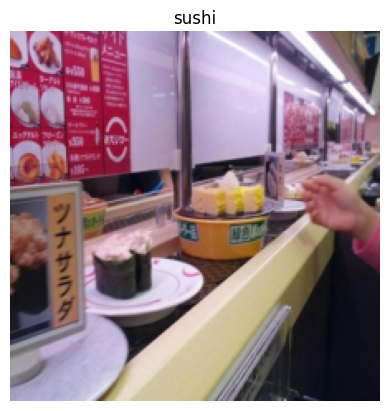

In [153]:
# PLot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")

### Replicate ViT architecture: Overview

### Equation 1: Split data into patches and creating the class, position and patch embeddings

Layer = input -> function -> output

* Input shape = (224, 224, 3)
* Output shape = ()

In [154]:
# Create example values

height = 224
width = 224
color_channels = 3
patch_size = 16

# Number of patches
number_of_patches = (height // patch_size) * (width // patch_size)
number_of_patches

196

In [155]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
# Output shape
embedding_layer_output_shape = (number_of_patches, color_channels * patch_size**2)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

### Turn a single image into patches.

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

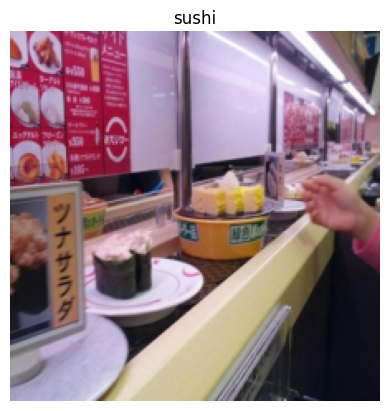

In [156]:
# View a single image
plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")

In [157]:
image.shape

torch.Size([3, 224, 224])

Text(0.5, 1.0, 'Top-row of the image')

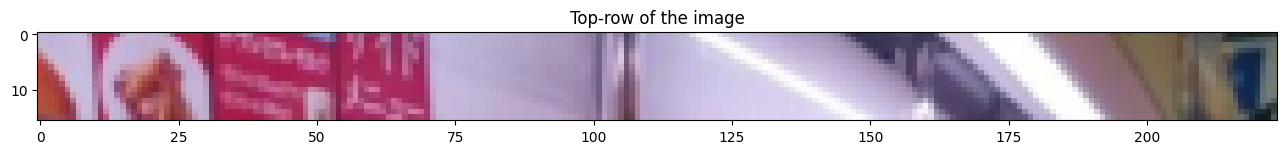

In [158]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)  # Change shape to (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])  # Plot the top-left patch
plt.title("Top-row of the image")

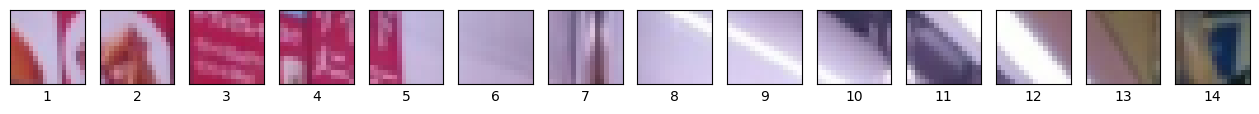

In [159]:
# Setup code to plot top row as patches

img_size = 224
patch_size = 16
number_of_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size."

# Create a series of subplots to visualize patches
fig, axes = plt.subplots(nrows=1, 
                         ncols=int(number_of_patches),
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))


for i, patch in enumerate(range(0, img_size, patch_size)):
    axes[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axes[i].set_xlabel(i+1)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

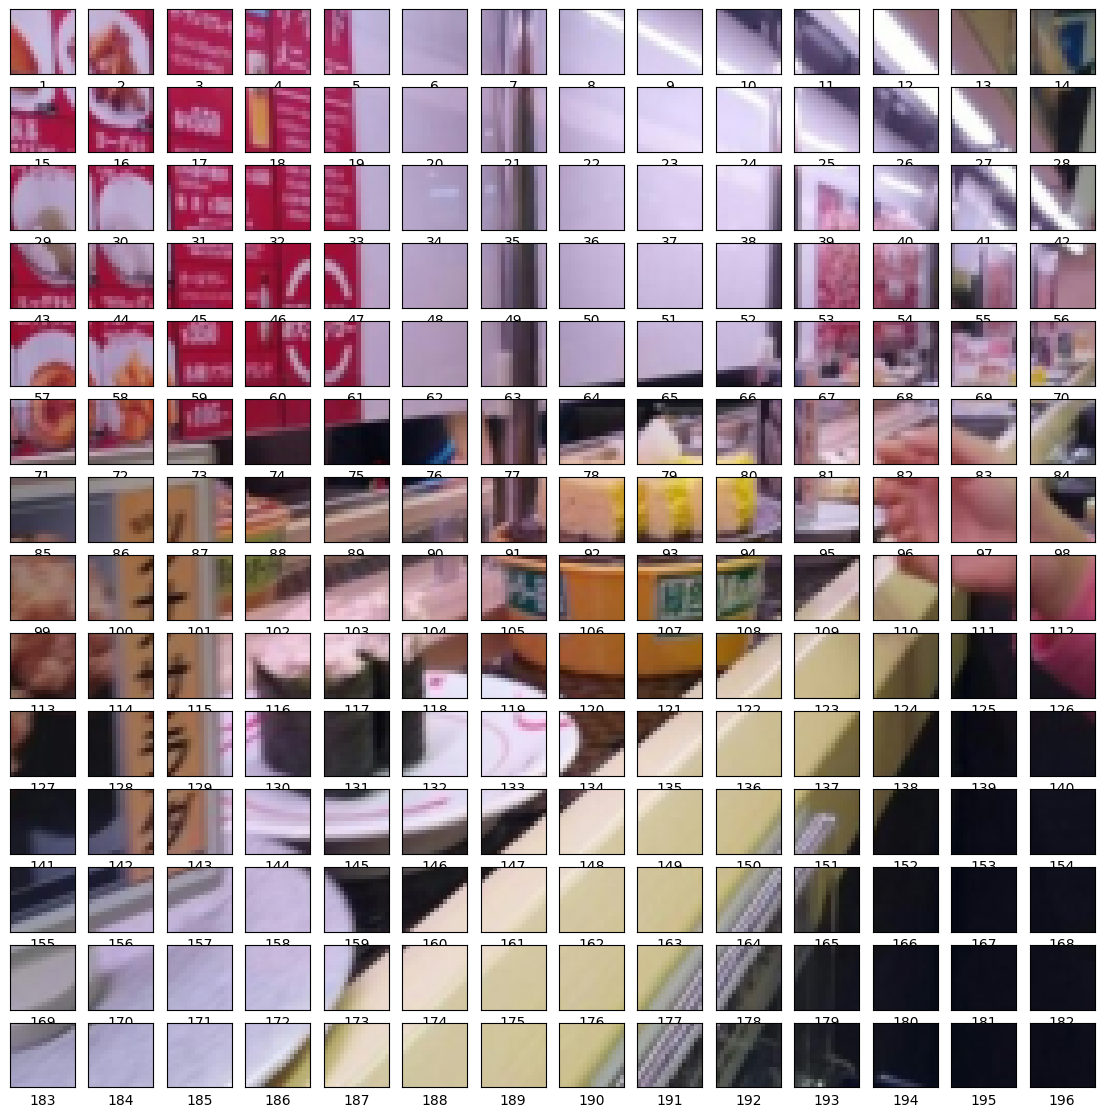

In [160]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
number_of_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size."

# Create a series of subplots to visualize patches
fig, axes = plt.subplots(
    nrows=int(number_of_patches),
    ncols=int(number_of_patches),
    figsize=(number_of_patches, number_of_patches),
    sharex=True,
    sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axes[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                         patch_width:patch_width+patch_size, :])
        axes[i, j].set_xlabel(f"{i * int(number_of_patches) + j + 1}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
                         

### Creating image patches and transforming them into embeddings.

In [161]:
# Create conv2d layer to turn an image into patches
from torch import nn

# Set the patch size
patch_size = 16

# Create a convolutional layer to extract patches
conv2d = nn.Conv2d(
    in_channels=3,  # Number of color channels in the image
    out_channels=3 * patch_size**2,  # Each patch will have 3 * patch_size^2 features
    kernel_size=patch_size,  # Patch size
    stride=patch_size,  # Move by patch size to get non-overlapping patches
    padding=0,  # No padding needed for non-overlapping patches
)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

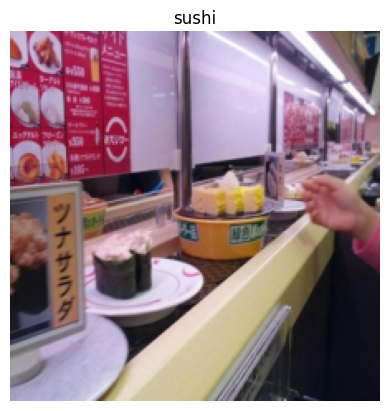

In [162]:
# View single image
plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")

In [163]:
# Pass the image through the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add batch dimension
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [164]:
flatten = image_out_of_conv.flatten(2,3)
flatten.shape  # Flatten the output to (batch_size, num_patches, patch_features)

torch.Size([1, 768, 196])

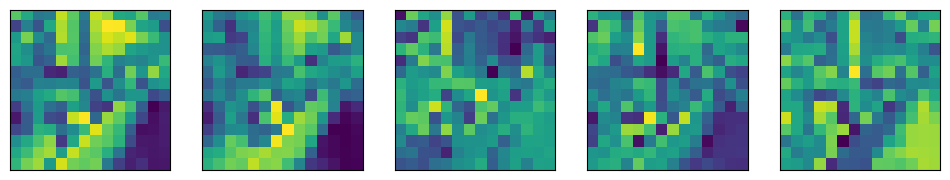

In [165]:
import random
random_indexes = random.sample(range(0, 768), k=5)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, index in enumerate(random_indexes):
    image_conv_map = image_out_of_conv[0, index, :, :]
    axes[i].imshow(image_conv_map.squeeze().detach().numpy())
    axes[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Flatten the embeddings using torch.nn.Flatten.

In [166]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [167]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(image_out_of_conv).shape  # Flatten the output to (batch_size, num_patches, patch_features)

torch.Size([1, 768, 196])

Image shape: torch.Size([3, 224, 224])
Image out of conv shape: torch.Size([1, 768, 14, 14])
Image out of conv flattened shape: torch.Size([1, 768, 196])


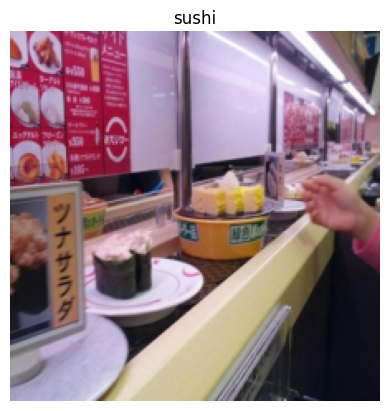

In [168]:
# Put everything together

plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")
print(f"Image shape: {image.shape}")

# Turn the image into patches
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add batch dimension
print(f"Image out of conv shape: {image_out_of_conv.shape}")

# Flatten the output
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Image out of conv flattened shape: {image_out_of_conv_flattened.shape}")

In [169]:
# Rearrange the output of flatten layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)  # (batch_size, num_patches, patch_features)
print(f"Image out of conv flattened rearranged shape: {image_out_of_conv_flattened_permuted.shape}")

Image out of conv flattened rearranged shape: torch.Size([1, 196, 768])


Single flattened feature map shape: torch.Size([1, 196])


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

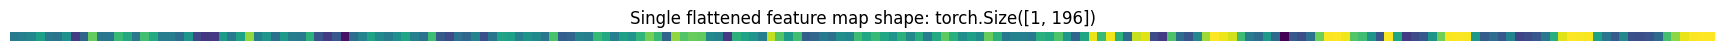

In [170]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

print(f"Single flattened feature map shape: {single_flattened_feature_map.shape}")

#Plot the single flattened feature map visualization
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Single flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis("off")

### Turning the ViT patch embedding layer into a PyTorch module

In [171]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size  # Size of each patch
        
        self.patcher = nn.Conv2d(
            in_channels=in_channels,  # Number of color channels in the image
            out_channels=embedding_dim,  # Each patch will have embedding_dim features
            kernel_size=patch_size,  # Patch size
            stride=patch_size,  # Move by patch size to get non-overlapping patches
            padding=0)  # No padding needed for non-overlapping patches
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the patch embedding layer.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_patches, embedding_dim).
        """
        image_resolution = x.shape[-1] 
        assert image_resolution % patch_size == 0, f"Image resolution {image_resolution} must be divisible by patch size {self.patch_size}."

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        x_permuted = x_flattened.permute(0, 2, 1)

        return x_permuted  # Return shape (batch_size, num_patches, embedding_dim)


In [172]:
set_seeds()

# Create a patch embedding layer
patchify = PatchEmbedding(
    in_channels=3,  # Number of color channels in the image
    patch_size=16,  # Patch size
    embedding_dim=768  # Embedding dimension
)

# Pass a single image through the patch embedding layer
print(f"Image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))  # Add batch dimension
print(f"Patch embedded image shape: {patch_embedded_image.shape}")

Image shape: torch.Size([1, 3, 224, 224])
Patch embedded image shape: torch.Size([1, 196, 768])


In [173]:
rand_image_tensor = torch.randn(1, 3, 224, 224)  # Random image tensor with shape (batch_size, in_channels, height, width)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)  # Random image tensor with shape (batch_size, in_channels, height, width)

# patchify(rand_image_tensor_bad)  # Should work


### Creating the class token embedding

In [174]:
patch_embedded_image.shape  # Should be (1, 196, 768) for a 224x224 image with 16x16 patches

torch.Size([1, 196, 768])

In [175]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]
print(f"Batch size: {batch_size}, Embedding dimension: {embedding_dim}")

Batch size: 1, Embedding dimension: 768


In [176]:
#Create class token embedding as a learnable parameter that share same shape as the patch embeddings
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dim),
    requires_grad=True)

class_token.shape  # Should be (1, 1, 768) for a batch size of 1 and embedding dimension of 768

torch.Size([1, 1, 768])

In [177]:
# Add the class token to the patch embedded image front
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image), 
    dim=1)  # Concatenate along the sequence dimension

print(patch_embedded_image_with_class_embedding)  # Should be (1, 197, 768) for a batch size of 1, 196 patches and 1 class token
print(f"Patch embedded image with class embedding shape: {patch_embedded_image_with_class_embedding.shape}")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6935,  0.2171, -0.0696,  ...,  0.3383, -0.4364,  0.2271],
         [-0.6361, -0.0612, -0.0808,  ...,  0.5279, -0.3241, -0.0193],
         ...,
         [-0.0552,  0.0259, -0.1092,  ...,  0.0866, -0.0429,  0.0328],
         [-0.0783,  0.0082, -0.0488,  ...,  0.0639, -0.0233,  0.0148],
         [-0.0777,  0.0113, -0.0479,  ...,  0.0549, -0.0288,  0.0216]]],
       grad_fn=<CatBackward0>)
Patch embedded image with class embedding shape: torch.Size([1, 197, 768])


### Creating the positional embeddings

Want to: create a 1d learnable positional embeddings and add them to the patch embeddings.

In [178]:
# View the sequence of patch embeddings with the prepended class token
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6935,  0.2171, -0.0696,  ...,  0.3383, -0.4364,  0.2271],
          [-0.6361, -0.0612, -0.0808,  ...,  0.5279, -0.3241, -0.0193],
          ...,
          [-0.0552,  0.0259, -0.1092,  ...,  0.0866, -0.0429,  0.0328],
          [-0.0783,  0.0082, -0.0488,  ...,  0.0639, -0.0233,  0.0148],
          [-0.0777,  0.0113, -0.0479,  ...,  0.0549, -0.0288,  0.0216]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [179]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

positional_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension),
    requires_grad=True)

positional_embedding, positional_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [180]:
# Add the positional embedding to the patch embedded image with class embedding
patch_and_positional_embedding = patch_embedded_image_with_class_embedding + positional_embedding
print(patch_and_positional_embedding)
print(f"Patch and positional embedding shape: {patch_and_positional_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3065, 1.2171, 0.9304,  ..., 1.3383, 0.5636, 1.2271],
         [0.3639, 0.9388, 0.9192,  ..., 1.5279, 0.6759, 0.9807],
         ...,
         [0.9448, 1.0259, 0.8908,  ..., 1.0866, 0.9571, 1.0328],
         [0.9217, 1.0082, 0.9512,  ..., 1.0639, 0.9767, 1.0148],
         [0.9223, 1.0113, 0.9521,  ..., 1.0549, 0.9712, 1.0216]]],
       grad_fn=<AddBackward0>)
Patch and positional embedding shape: torch.Size([1, 197, 768])


### Putting it all together: from image to embedding.

In [181]:
# Set the seed
set_seeds(42)

# Set the patch size
patch_size = 16

# Print shapes of the original image and get the image dimensions
print(f"Original image shape: {image.shape}")
color_channels, height, width = image.shape
print(f"Image height: {height}")
print(f"Image width: {width}")
print(f"Image color channels: {color_channels}")

# Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Image tensor with batch dimension: {x.shape}")

# Create a patch embedding layer
patch_embedding_layer = PatchEmbedding(
    in_channels=color_channels,
    patch_size=patch_size,
    embedding_dim=768
)

# Pass the image through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedded image shape: {patch_embedding.shape}")


# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]

# Create a class token embedding as a learnable parameter that share same shape as the patch embeddings
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dim),
    requires_grad=True
)
print(f"Class token embedding shape: {class_token.shape}")

# Add the class token to the patch embedded image
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create a learnable positional embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dim),
    requires_grad=True
)
print(f"Position embedding shape: {position_embedding.shape}")

# Add the positional embedding to the patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch embedding with class token and positional embedding shape: {patch_and_position_embedding.shape}")

Original image shape: torch.Size([3, 224, 224])
Image height: 224
Image width: 224
Image color channels: 3
Image tensor with batch dimension: torch.Size([1, 3, 224, 224])
Patch embedded image shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch embedding with class token and positional embedding shape: torch.Size([1, 197, 768])


### Equation 2: Multi-head self-attention.

In [182]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Create a multi-head self-attention block.
    """
    def __init__(
        self,
        embedding_dim: int=768,
        num_heads: int=12,
        attn_dropout: float = 0.1):

        super().__init__()
        # Create a norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create a multi-head attention layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True,
            )
        
    def forward(self, x: torch.Tensor):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,
            key=x,
            value=x,
            need_weights=False)
        
        return attn_output

In [183]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dim=768,
    num_heads=12,
    attn_dropout=0
)

# Pass the patch and positional embedding to the MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

# Print the shape of the MSA output
print(f"Patch and positional embedding shape: {patch_and_position_embedding.shape}")
print(f"Patched image through MSA block shape: {patched_image_through_msa_block.shape}")

Patch and positional embedding shape: torch.Size([1, 197, 768])
Patched image through MSA block shape: torch.Size([1, 197, 768])


In [184]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3065, 1.2171, 0.9304,  ..., 1.3383, 0.5636, 1.2271],
         [0.3639, 0.9388, 0.9192,  ..., 1.5279, 0.6759, 0.9807],
         ...,
         [0.9448, 1.0259, 0.8908,  ..., 1.0866, 0.9571, 1.0328],
         [0.9217, 1.0082, 0.9512,  ..., 1.0639, 0.9767, 1.0148],
         [0.9223, 1.0113, 0.9521,  ..., 1.0549, 0.9712, 1.0216]]],
       grad_fn=<AddBackward0>)

In [185]:
patched_image_through_msa_block

tensor([[[-0.2546, -0.2028,  0.0917,  ..., -0.4872,  0.9056, -0.5157],
         [-0.2624, -0.1974,  0.0983,  ..., -0.4812,  0.9185, -0.5232],
         [-0.2643, -0.1982,  0.0973,  ..., -0.4785,  0.9188, -0.5256],
         ...,
         [-0.2597, -0.1825,  0.1125,  ..., -0.4780,  0.9121, -0.5214],
         [-0.2647, -0.1968,  0.1033,  ..., -0.4756,  0.9152, -0.5241],
         [-0.2646, -0.1970,  0.1025,  ..., -0.4756,  0.9149, -0.5235]]],
       grad_fn=<TransposeBackward0>)

## MLP block.

In [186]:
class MLPBlock(nn.Module):
    """Create a multi-layer perceptron block.
    """
    def __init__(self, embedding_dim: int=768, mlp_size: int=3072, dropout: float=0):
        super().__init__()

        # Create a layer norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create a MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [187]:
# Create an instance of the MLP block
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0)

# Pass the patched image through the MLP block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

# Print the shape of the MLP output
print(f"Patched image through MLP block shape: {patched_image_through_mlp_block.shape}")

# Print the shape of the MSA output
print(f"Patched image through MSA block shape: {patched_image_through_msa_block.shape}")

Patched image through MLP block shape: torch.Size([1, 197, 768])
Patched image through MSA block shape: torch.Size([1, 197, 768])


In [188]:
patched_image_through_msa_block

tensor([[[-0.2546, -0.2028,  0.0917,  ..., -0.4872,  0.9056, -0.5157],
         [-0.2624, -0.1974,  0.0983,  ..., -0.4812,  0.9185, -0.5232],
         [-0.2643, -0.1982,  0.0973,  ..., -0.4785,  0.9188, -0.5256],
         ...,
         [-0.2597, -0.1825,  0.1125,  ..., -0.4780,  0.9121, -0.5214],
         [-0.2647, -0.1968,  0.1033,  ..., -0.4756,  0.9152, -0.5241],
         [-0.2646, -0.1970,  0.1025,  ..., -0.4756,  0.9149, -0.5235]]],
       grad_fn=<TransposeBackward0>)

In [189]:
patched_image_through_mlp_block

tensor([[[-0.0839, -0.0417,  0.0839,  ...,  0.0200, -0.1256,  0.1717],
         [-0.0822, -0.0434,  0.0840,  ...,  0.0229, -0.1253,  0.1641],
         [-0.0769, -0.0430,  0.0821,  ...,  0.0237, -0.1252,  0.1677],
         ...,
         [-0.0835, -0.0418,  0.0806,  ...,  0.0283, -0.1243,  0.1693],
         [-0.0844, -0.0397,  0.0881,  ...,  0.0274, -0.1255,  0.1679],
         [-0.0839, -0.0401,  0.0872,  ...,  0.0269, -0.1258,  0.1677]]],
       grad_fn=<ViewBackward0>)

## Create the transformer encoder.

Combination of alternating blocks of MSA and MLP.

In [190]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, num_heads: int=12, mlp_size: int=3072, mlp_dropout: float=0, attn_dropout: float=0):
        super().__init__()

        # Create a multi-head self-attention block
        self.msa_block = MultiHeadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout)
        
        # Create a multi-layer perceptron block
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout)
        
    def forward(self, x: torch.Tensor):
        x = self.msa_block(x) + x # residual connection
        x = self.mlp_block(x) + x # residual connection
        return x

In [191]:
# Create an instance of the transformer encoder block
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block, input_size=(1, 196, 768), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 196, 768]        [1, 196, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 196, 768]        [1, 196, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 196, 768]        [1, 196, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 196, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 196, 768]        [1, 196, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 196, 768]        [1, 196, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 196, 768]        [1, 196, 768]        --                   True
│    │    └─Linear (0)                     

### Create a transformer encoder layer with in-built PyTorch layers.

In [192]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True,
)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [193]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer, input_size=(1, 196, 768), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 196, 768]        [1, 196, 768]        --                   True
├─LayerNorm (norm1)                                [1, 196, 768]        [1, 196, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 196, 768]        [1, 196, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 196, 768]        [1, 196, 768]        --                   --
├─LayerNorm (norm2)                                [1, 196, 768]        [1, 196, 768]        1,536                True
├─Linear (linear1)                                 [1, 196, 768]        [1, 196, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 196, 3072]       [1, 196, 3072]       --                   --
├─Linear (linear2)                             

## Putting it all together to create a ViT

In [194]:
# Create a ViT class
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters.
    """
    def __init__(
        self,
        image_size: int=224,
        in_channels: int=3,
        patch_size: int=16,
        num_transformer_layers: int=12,
        embedding_dim: int=768,
        mlp_size: int=3072,
        num_heads: int=12,
        attn_dropout: float=0,
        mlp_dropout: float=0.1,
        embedding_dropout: float=0.1,
        num_classes: int=1000):

        super().__init__()

        # Make an assertion that the image size is divisible by the patch size
        assert image_size % patch_size == 0, f"Image size must be divisible by patch size, image_size: {image_size}, patch_size: {patch_size}."

        # Calculate the number of patches (height * width)/patch_size^2
        self.num_patches = (image_size // patch_size) ** 2

        # Create learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)

        # Create embedding dropout layer
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim)
        
        # Create transformer encoder block
        self.transformer_encoder = nn.Sequential(*[
            TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=mlp_dropout,
                attn_dropout=attn_dropout)
            for _ in range(num_transformer_layers)])
        
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )
        
    def forward(self, x: torch.Tensor):
        # Get the batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Create patch embedding
        x = self.patch_embedding(x)

        # Concatenate class token with patch embedding
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding
        x = self.position_embedding + x

        # Dropout
        x = self.embedding_dropout(x)

        # Pass through transformer encoder layers
        x = self.transformer_encoder(x)

        # Put the 0th index logits through classifier head
        x = self.classifier(x[:, 0])

        return x

In [195]:
set_seeds()

# Create a random tensor with the same shape as the image size
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of the ViT class with number of classes
vit = ViT(num_classes=len(class_names)).to(device)

# Pass the random image through the ViT model
vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

## Getting a visual summary of the ViT model

In [196]:
summary(model=vit, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## Setting up training code for our ViT model

We've replicated the ViT architecture in PyTorch, now let's create a training loop to train it the food vision dataset.

### Create an optimizer.

In [197]:
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=0.1)

### Create a loss function.

Paper doesn't mention the loss function so we will use cross entropy loss for multi class classification.

In [198]:
loss_fn = nn.CrossEntropyLoss()

## Training our ViT model

In [199]:
device

'cpu'

In [200]:
from going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=0.1)

loss_fn = nn.CrossEntropyLoss()

# results = engine.train(
#     model=vit.to(device),
#     train_dataloader=train_dataloader,
#     test_dataloader=test_dataloader,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     epochs=1,
#     device=device
# )

In [201]:
# from helper_functions import plot_loss_curves

# plot_loss_curves(results)

### Using a pre-trained ViT model from PyTorch.

In [202]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [203]:
# Get pretrained weights for ViT base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a Vit model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [204]:
summary(model=pretrained_vit, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Preparing data for pre-trained ViT model.

In [205]:
# Get automatic transforms for ViT
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [206]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

In [207]:
from going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(
    params=pretrained_vit.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=0.1)

loss_fn = nn.CrossEntropyLoss()

results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

 10%|█████████████████████████                                                                                                                                                                                                                                 | 1/10 [00:11<01:42, 11.35s/it]

Epoch: 1 | train_loss: 0.8331 | train_acc: 0.6484 | test_loss: 0.6419 | test_acc: 0.9097


 20%|██████████████████████████████████████████████████                                                                                                                                                                                                        | 2/10 [00:22<01:30, 11.25s/it]

Epoch: 2 | train_loss: 0.4818 | train_acc: 0.8906 | test_loss: 0.4132 | test_acc: 0.9410


 30%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 3/10 [00:33<01:18, 11.25s/it]

Epoch: 3 | train_loss: 0.3173 | train_acc: 0.9414 | test_loss: 0.3263 | test_acc: 0.9410


 40%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 4/10 [00:45<01:07, 11.26s/it]

Epoch: 4 | train_loss: 0.2536 | train_acc: 0.9531 | test_loss: 0.2643 | test_acc: 0.9688


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 5/10 [00:56<00:56, 11.27s/it]

Epoch: 5 | train_loss: 0.2030 | train_acc: 0.9531 | test_loss: 0.2430 | test_acc: 0.9410


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 6/10 [01:07<00:45, 11.35s/it]

Epoch: 6 | train_loss: 0.1866 | train_acc: 0.9609 | test_loss: 0.2187 | test_acc: 0.9410


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 7/10 [01:19<00:33, 11.33s/it]

Epoch: 7 | train_loss: 0.1739 | train_acc: 0.9609 | test_loss: 0.2203 | test_acc: 0.9410


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 8/10 [01:30<00:22, 11.31s/it]

Epoch: 8 | train_loss: 0.1496 | train_acc: 0.9648 | test_loss: 0.2203 | test_acc: 0.9410


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 9/10 [01:42<00:11, 11.50s/it]

Epoch: 9 | train_loss: 0.1963 | train_acc: 0.9766 | test_loss: 0.1951 | test_acc: 0.9410


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.43s/it]

Epoch: 10 | train_loss: 0.1455 | train_acc: 0.9570 | test_loss: 0.1852 | test_acc: 0.9479


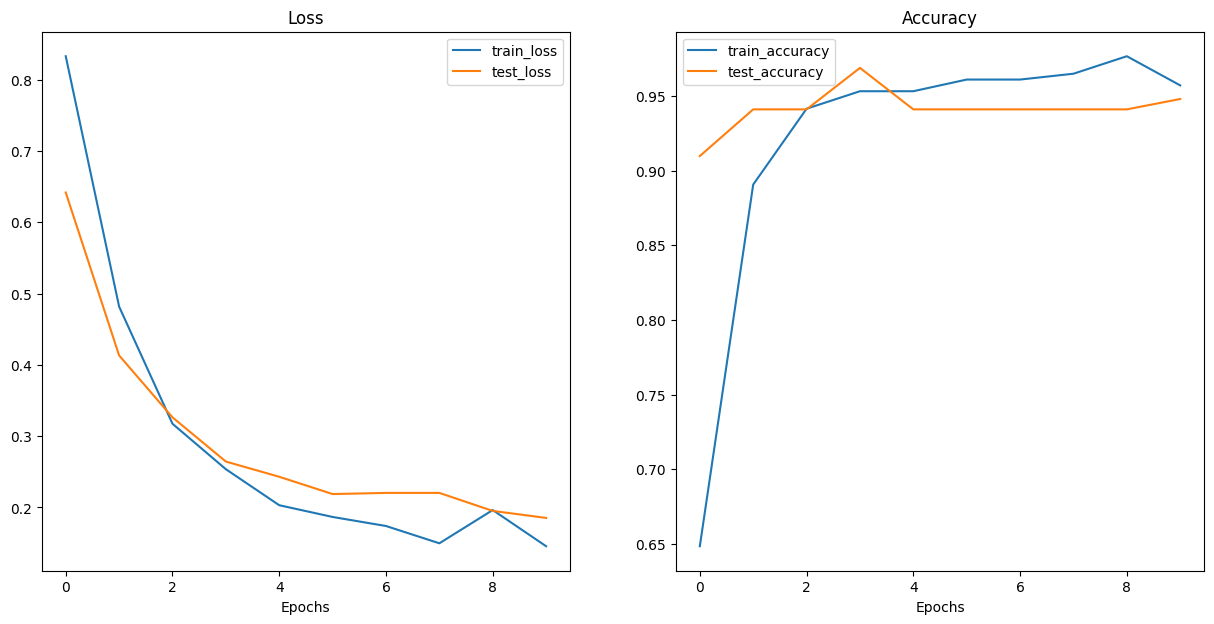

In [208]:
plot_loss_curves(results)

### Save the best model

In [209]:
from going_modular import utils

utils.save_model(model=pretrained_vit, target_dir="models", model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [210]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)

print(f"Pretrained vit feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained vit feature extractor model size: 327 MB


In [211]:
image_path

WindowsPath('data/pizza_steak_sushi')

data\pizza_steak_sushi\04-pizza-dad.jpeg already exists, skipping download.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0940216..2.4847243].


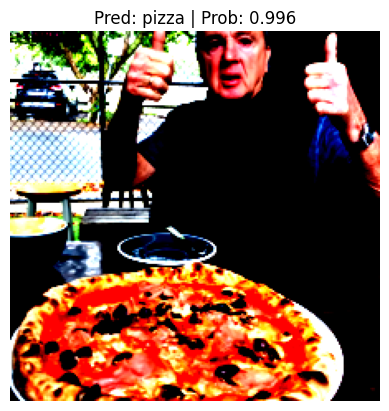

In [212]:
import requests

# Import function to make predictions on images and plot them
from helper_functions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=vit_transforms)